In [1]:
using EvoTrees
using CSV
using DataFrames
using Plots
using Random
using Statistics
using Interpolations
using CategoricalArrays

include(chop(@__DIR__; tail = 5)*"/plotting.jl")

data = Matrix(CSV.read(chop(@__DIR__; tail = 5)*"data/winequality-red.csv", DataFrame));

In [2]:
Random.seed!(1)
data = data[shuffle(1:end), :]

train_split::Int = floor(0.75 * length(data[:, 1]))

x_train = data[1:train_split, 1:11];
y_train = data[1:train_split, 12];

x_test = data[train_split+1:end, 1:11];
y_test = data[train_split+1:end, 12];

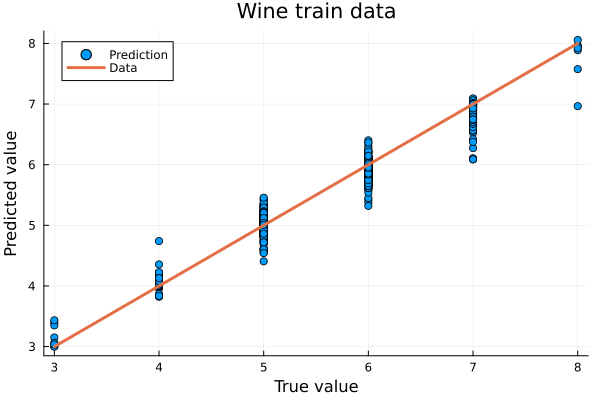

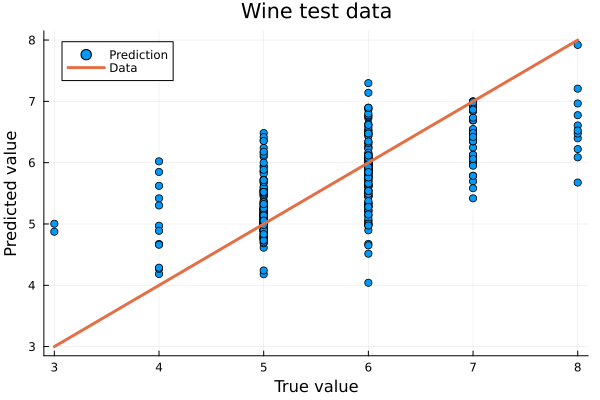

In [7]:
config = EvoTreeRegressor(nrounds=500, max_depth=7)
model = fit_evotree(config; x_train, y_train, verbosity=0)

pred_train = EvoTrees.predict(model, x_train)
pred_test = EvoTrees.predict(model, x_test)

display(plot(y_train, 
    [pred_train, y_train], 
    title="Wine train data", 
    label=["Prediction" "Data"],
    xlabel="True value",
    xlims=(2.9,8.1),
    ylabel="Predicted value" ,
    markershape=[:circle :none], 
    seriestype=[:scatter :line], 
    lw=3))

plot(y_test, 
    [pred_test, y_test], 
    title="Wine test data", 
    label=["Prediction" "Data"], 
    xlabel="True value",
    xlims=(2.9,8.1),
    ylabel="Predicted value",
    markershape=[:circle :none], 
    seriestype=[:scatter :line], 
    lw=3)

In [8]:
r2_score_test = 1 - sum((y_test .- pred_test).^2) / sum((y_test .- mean(y_test)).^2)

0.4600915805880045

In [17]:
trees = [50, 100, 250, 500, 750, 1000, 1500, 2000]
depths = [2, 3, 4, 5, 6, 7, 9]
bins = [8, 16, 32, 128, 255]

r2_vals = Array{Any}(undef, length(bins))

for bin in eachindex(bins)

    r2_values_test = Matrix{Float64}(undef, length(trees), length(depths))

    for depth in eachindex(depths)

        config = EvoTreeRegressor(nrounds=maximum(trees), max_depth=depths[depth], nbins=bins[bin]);
        model = fit_evotree(config; x_train, y_train, verbosity=0);

        for n_trees in eachindex(trees)

            pred_train = EvoTrees.predict(model, x_train, ntree_limit=trees[n_trees])
            pred_test = EvoTrees.predict(model, x_test, ntree_limit=trees[n_trees])
        
            nrmse_train = sqrt(mean((y_train .- pred_train).^2)) / mean(y_train)
            nrmse_test = sqrt(mean((y_test .- pred_test).^2)) / mean(y_test)
        
            r2_score_train = 1 - sum((y_train .- pred_train).^2) / sum((y_train .- mean(y_train)).^2)
            r2_score_test = 1 - sum((y_test .- pred_test).^2) / sum((y_test .- mean(y_test)).^2)
        
            r2_values_test[n_trees, depth] = r2_score_test
        
        end

    end

    r2_vals[bin] = r2_values_test

end

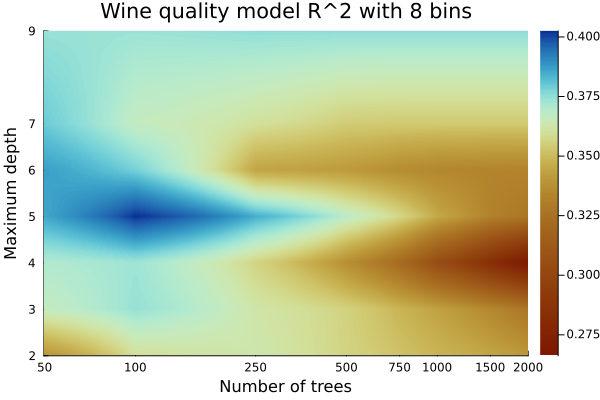

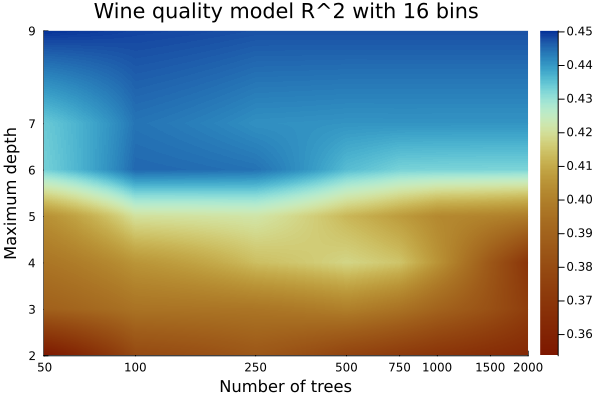

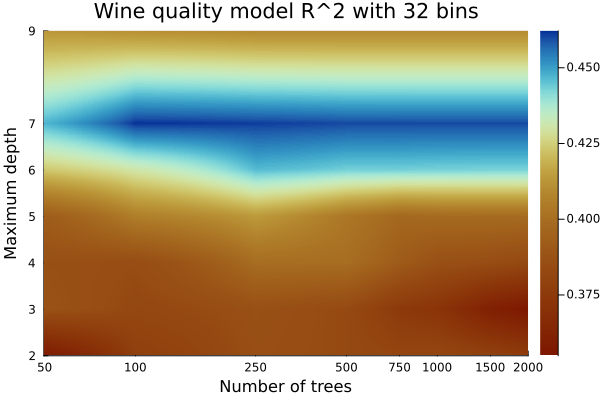

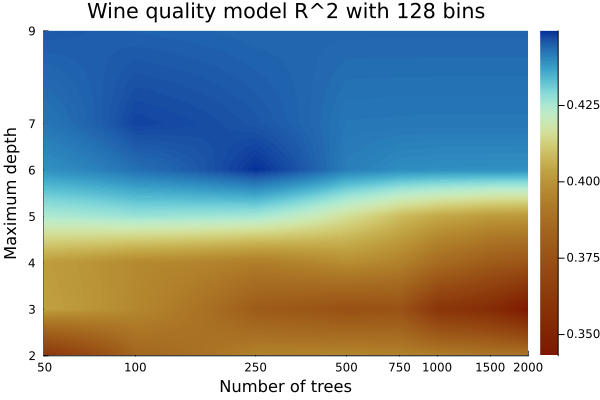

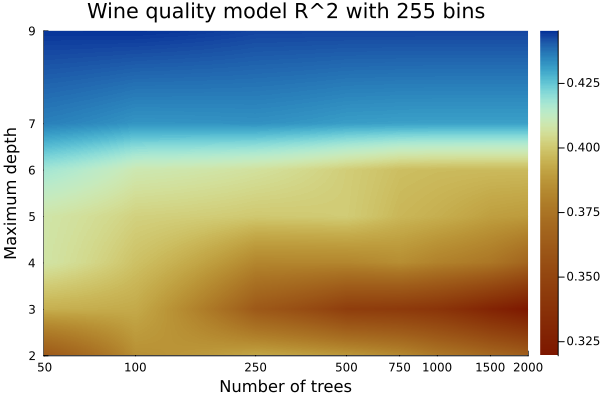

In [18]:
for bin in eachindex(bins)
    display(plot_model_quality(trees, depths, r2_vals[bin]; plot_title="Wine quality model R^2 with $(bins[bin]) bins", label_x="Number of trees", label_y="Maximum depth"))
end

In [19]:
for bin in eachindex(bins) println(findmax(r2_vals[bin])) end

(0.4025534760708669, CartesianIndex(2, 4))
(0.45029870951461426, CartesianIndex(1, 7))
(0.46219068260988005, CartesianIndex(2, 6))
(0.4494332167835965, CartesianIndex(3, 5))
(0.44534025865085614, CartesianIndex(2, 7))


In [20]:
r2_vals[3]

8×7 Matrix{Float64}:
 0.356594  0.387043  0.385813  0.391951  0.423446  0.447149  0.412604
 0.377195  0.381955  0.384335  0.405764  0.430528  0.462191  0.410627
 0.385315  0.386035  0.399225  0.41363   0.446318  0.461191  0.408996
 0.382879  0.382813  0.399332  0.402748  0.443368  0.460108  0.409016
 0.380881  0.373901  0.391236  0.396964  0.443554  0.460035  0.409016
 0.381228  0.37092   0.385946  0.398176  0.443125  0.460024  0.409016
 0.378068  0.359459  0.384327  0.398414  0.443029  0.460023  0.409016
 0.375292  0.35491   0.382029  0.39829   0.443028  0.460023  0.409016